In [1]:
# Load required packages
#from dynamic_stock_model import DynamicStockModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define formating for graphs 
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'axes.linewidth': .5})
plt.rcParams.update({'legend.fontsize': 10})
plt.rcParams['svg.fonttype'] = 'none' # So .svg does not convert text to paths
 
fig_size_mult = 1.3
fig_size_tuple = (4 * fig_size_mult, 3 * fig_size_mult);
fig_size_tuple_double = (8 * fig_size_mult * .5/ .7, 3 * fig_size_mult * .5/ .7);
fig_dpi = 100

In [2]:
# Read data
# Spreadsheet came from: https://pubs.acs.org/doi/abs/10.1021/es502930w
Cars_Datafile  = pd.read_excel('../data/es502930w_si_002.xlsx', 
                               sheet_name='3.Use', 
                               skiprows = 5, 
                               usecols = 'A,C,F,I',
                              )

Cars_Datafile.columns = ['Year', 'Population', 'Car/capita', 'Lifetime']

# This data is from: https://pubs.acs.org/doi/pdf/10.1021/es303149z
# However, the origin of the numbers below is unclear (the actual numbers are not provided with the paper)
Steel_stock_model = pd.read_csv('../data/steel_stocks.csv')

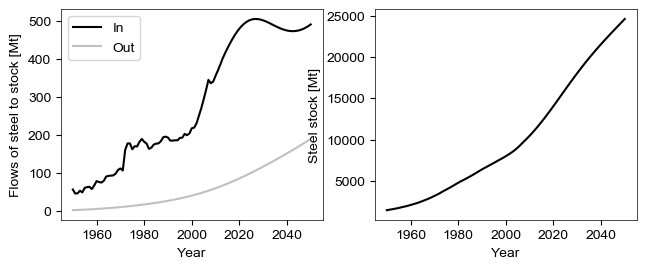

In [3]:
# Steel stocks
fig, ax=plt.subplots(1, 2, figsize = fig_size_tuple_double, 
                     dpi = fig_dpi, facecolor = 'w', edgecolor = 'k', sharex=True)

# Flows to stock
ax[0].plot(Steel_stock_model['Year'], Steel_stock_model['Inflow [kt]'] / 1e3, label = 'In', color = 'k')
ax[0].plot(Steel_stock_model['Year'], Steel_stock_model['Outflow [kt]'] / 1e3, label = 'Out', color = 'silver')
ax[0].legend()

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Flows of steel to stock [Mt]')

# Stock of glass
ax[1].plot(Steel_stock_model['Year'], Steel_stock_model['Stocks [kg per person]'] * 
           Cars_Datafile['Population'] / 1e9, color = 'k')

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Steel stock [Mt]')

plt.show()

In [4]:
# Estimate of ratio of glass to steel in buildings - not used
# Steel in walls
steel_in_walls = 65 # kg/m^3; Cobb, 2008
wall_thickness = [.15, .2] # m; min, max; No idea where this came from
rebar_in_buildings = .44 # Ratio of rebar in buildings to total amount of steel; Cullen et al., 2012
steel_in_walls = steel_in_walls * np.mean(wall_thickness) / rebar_in_buildings

# Glass in walls
window_to_wall = 0.3 # Assumed...
glass_density = 2440 # kg/m^3
window_thickness = 0.006 # mm; Assumed...
glass_in_walls = window_to_wall * glass_density * window_thickness

gs_ratio_estimate = glass_in_walls / steel_in_walls # This is just a sannity check and is not used...

In [5]:
# Estimate ratio of glass to steel in buildings from available data points
building_flows = pd.read_excel('../data/glass_paper.xlsx', sheet_name='Building_flows')

gs_ratio_in = []
gs_ratio_out = []

for counter_i, i in building_flows.iterrows():
    
    if i['Year'] not in [2010, 2015]: # Ignore these years because thare are no outflows
    
        gs_ratio_in.append((i['In'] / 
                            Steel_stock_model[Steel_stock_model['Year'] == i['Year']]['Inflow [kt]'].values[0] 
                            * 1e3))
            
        gs_ratio_out.append((i['Out'] / 
                             Steel_stock_model[Steel_stock_model['Year'] == i['Year']]['Outflow [kt]'].values[0] 
                             * 1e3))

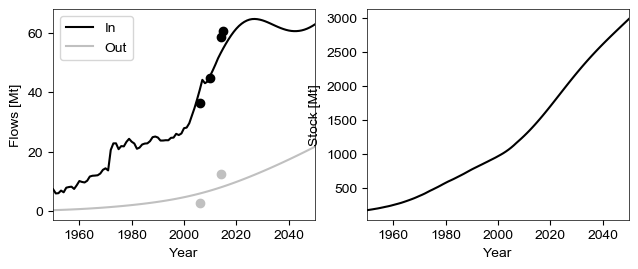

In [6]:
# Glass stocks
fig, ax=plt.subplots(1, 2, figsize = fig_size_tuple_double, 
                     dpi = fig_dpi, facecolor = 'w', edgecolor = 'k', sharex = True)

# Calculate flows
glass_buildings_in = Steel_stock_model['Inflow [kt]'] / 1e3 * np.mean(gs_ratio_in)
glass_buildings_out = Steel_stock_model['Outflow [kt]'] / 1e3 * np.mean(gs_ratio_out)

# Flows to stock
ax[0].plot(Steel_stock_model['Year'], glass_buildings_in, label = 'In', color = 'k')
ax[0].scatter(building_flows['Year'], building_flows['In'], color = 'k')

ax[0].plot(Steel_stock_model['Year'], glass_buildings_out, label = 'Out', color = 'silver')
ax[0].scatter(building_flows['Year'], building_flows['Out'], color = 'silver')


ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Flows [Mt]')
ax[0].set_xlim(left = 1950, right = 2050)

# The stock gets an average of everything
gs_ratio = np.mean(gs_ratio_in + gs_ratio_out)

# Calculate stock
glass_buildings_stock = (Steel_stock_model['Stocks [kg per person]'] * 
           Cars_Datafile['Population'] / 1e9 * gs_ratio)

# Stock of glass
ax[1].plot(Steel_stock_model['Year'], glass_buildings_stock, color = 'k')

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Stock [Mt]')

plt.savefig('../outputs/buildings_glass_flows_and_stocks.svg')
plt.show()

# Save data from the graphs
buildings_flows_and_stock = pd.DataFrame(
    {'Year': Steel_stock_model['Year'],
     'Flows In [Mt]': glass_buildings_in,
     'Flows Out [Mt]': glass_buildings_out,
     'Stock [Mt]': glass_buildings_stock,
    })

buildings_flows_and_stock.to_csv('../outputs/glass_buildings_flows_and_stock.csv')